In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Mount Google Drive
#drive.mount('/content/drive', force_remount=True)

# Set paths
#data_path = "C:/Users/Karam Sallam/Desktop/ODIR-5K/ODIR-5K/full_df.csv"
#images_dir = "C:/Users/Karam Sallam/Desktop/ODIR-5K/preprocessed_images/"
#image_path = "C:/Users/Karam Sallam/Desktop/ODIR-5K/preprocessed_images/"

data_set=pd.read_csv("D:/ODIR-5K/full_df.csv")
# Set paths
data_path = r"D:/ODIR-5K/full_df.csv"
images_dir = r"D:/ODIR-5K/preprocessed_images"

# Load CSV dataset
df = pd.read_csv(data_path)

In [5]:
data=df
def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
    
    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [6]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [7]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

In [8]:
# Multi-class labeling function based on keywords
def get_label_from_keywords(text):
    text = text.lower()
    if "cataract" in text:
        return 3  # Cataract
    elif "diabetes" in text:
        return 1  # Diabetes
    elif "glaucoma" in text:
        return 2  # Glaucoma
    elif "hypertension" in text:
        return 5  # Hypertension
    elif "myopia" in text:
        return 6  # Pathological Myopia
    elif "age related" in text or "macular degeneration" in text:
        return 4  # Age related Macular Degeneration
    elif "other" in text or "abnormalities" in text:
        return 7  # Other diseases/abnormalities
    else:
        return 0  # Normal

In [9]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = images_dir
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        #image category here would be either normal or cataract
        imgpath = os.path.join(dataset_dir,img);
        
        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

In [10]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)
len(dataset)

100%|██████████| 324/324 [00:02<00:00, 157.59it/s]


5396

In [11]:
print(f"Dataset length: {len(dataset)}")

Dataset length: 5396


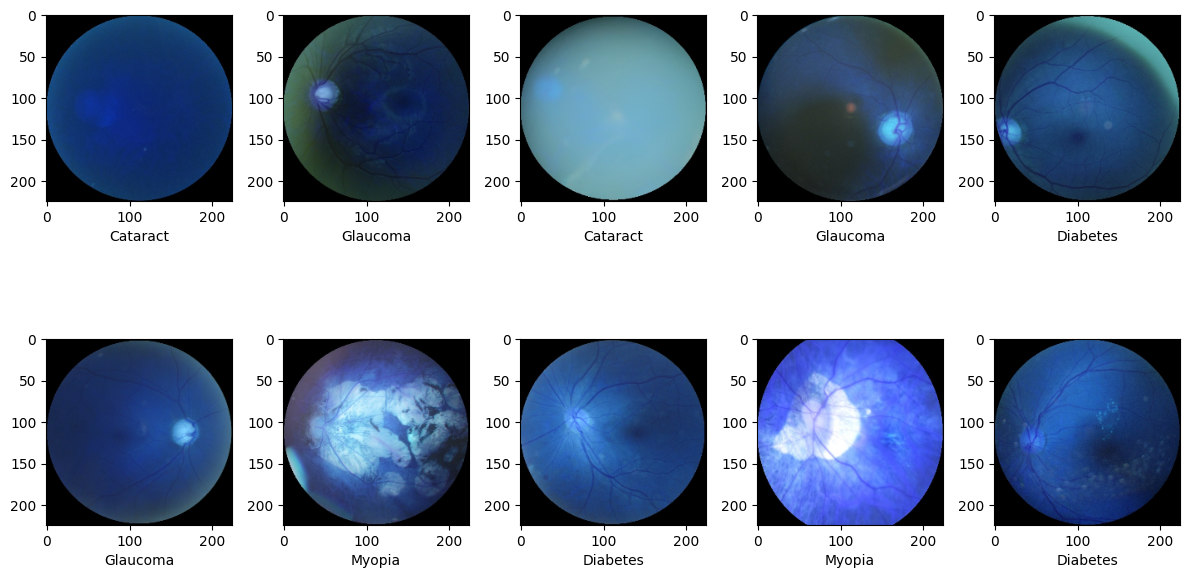

In [12]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
           
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [13]:
#random.shuffle(dataset)
X = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
Y = np.array([i[1] for i in dataset])
# Convert labels to one-hot encoding
Y = to_categorical(Y, num_classes=8)
print(Y.shape)

(5396, 8)


In [14]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:

# Split data into training, validation, and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

#from imblearn.under_sampling import RandomUnderSampler

# Randomly undersample the majority class
#undersampler = RandomUnderSampler()
#X_train, Y_train = undersampler.fit_resample(X_train, Y_train)

In [16]:
print(X_val.shape)

(432, 224, 224, 3)


In [23]:
# Load pre-trained ResNet50 model without the top layer
from tensorflow.keras.callbacks import EarlyStopping
base_model = ResNet50(include_top=False, input_shape=(image_size, image_size, 3))
# Freeze the base model layers
for layer in base_model.layers[:200]:
    layer.trainable = False


# Add custom layers on top of the ResNet50 base

#x = base_model.output
#x = Flatten()(x)
#x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#x = Dropout(0.5)(x)
#x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#x = Dropout(0.4)(x)
#x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#x = Dropout(0.3)(x)
#x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
output = Dense(8, activation='softmax')(x)  # 8 classes for multi-class classification

# Define the final model
model = Model(inputs=base_model.input, outputs=output)
from tensorflow.keras.metrics import Recall,Precision

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=[
                  Recall(name="recall"),
                  Precision(name="Precision"),
                  "accuracy"
                    ])

In [24]:
print(Y)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Set up K-Fold cross-validation
from sklearn.model_selection import KFold
k = 10  # Number of folds
kf = KFold(n_splits=k)

# Store the scores for each fold
scores = []

X_data=X_train
Y_data_one_hot=Y_train
for train_index, val_index in kf.split(X_data):
    X_train, X_val = X_train[train_index], X_data[val_index]
    Y_train, Y_val = Y_data_one_hot[train_index], Y_data_one_hot[val_index]

    # Compute class weights
    #class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_data), y=Y_data[train_index])
    #class_weight_dict = dict(enumerate(class_weights))

    # Create the model
    # Train the model
    model.fit(X_train, Y_train, batch_size=64, epochs=50,  # Adjust epochs as needed
              validation_data=(X_val, Y_val))

    # Evaluate the model
    score = model.evaluate(X_val, Y_val, verbose=0)
    scores.append(score[1])  # Append accuracy

# Print the average accuracy across all folds
print(f'Average accuracy over {k} folds: {np.mean(scores)}')




#model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_val, Y_val))

Epoch 1/50
28/28 [==============================] - 14s 512ms/step - loss: 1.0459 - recall: 0.7759 - Precision: 0.8702 - accuracy: 0.8250 - val_loss: 0.7563 - val_recall: 0.8995 - val_Precision: 0.9372 - val_accuracy: 0.9045
Epoch 2/50
28/28 [==============================] - 14s 518ms/step - loss: 0.8328 - recall: 0.8111 - Precision: 0.8810 - accuracy: 0.8385 - val_loss: 0.6251 - val_recall: 0.8894 - val_Precision: 0.9219 - val_accuracy: 0.8945
Epoch 3/50
28/28 [==============================] - 22s 777ms/step - loss: 0.7335 - recall: 0.8390 - Precision: 0.8929 - accuracy: 0.8664 - val_loss: 0.5745 - val_recall: 0.8894 - val_Precision: 0.9365 - val_accuracy: 0.9045
Epoch 4/50
28/28 [==============================] - 35s 1s/step - loss: 0.6521 - recall: 0.8547 - Precision: 0.9096 - accuracy: 0.8826 - val_loss: 0.5989 - val_recall: 0.8844 - val_Precision: 0.9263 - val_accuracy: 0.9045
Epoch 5/50
28/28 [==============================] - 30s 1s/step - loss: 0.6870 - recall: 0.8452 - Preci

In [ ]:
print(class_weights)

In [ ]:
# Train the model
#hist = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_val, Y_val))

In [ ]:
history_dict = hist.history

    # Plot training & validation accuracy values
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

    # Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loss,accuracy = model.evaluate(X_test,Y_test)

In [ ]:
model.save('my_model.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)

In [ ]:
pip install seaborn


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:")
print(report)

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 8  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'pink', 'brown', 'gray']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("MobileNetV2.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,verbose=1)

from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2


train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])
#splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define variables to track the best model
best_model = None
best_score = 0.0

# Evaluate the model
scores = []
for train_index, test_index in kfold.split(train_x):
    # Get the training and testing data for this fold
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train = to_categorical(train_y[train_index], num_classes=8)
    y_test = to_categorical(train_y[test_index], num_classes=8)
    
    model=get_model(MobileNetV2)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=64,
        epochs=100,
        callbacks=[checkpoint,earlystop]

    )
    
    import matplotlib.pyplot as plt

    # Access training history
    history_dict = history.history

    # Plot training & validation accuracy values
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Train Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
